# 🔍 Chrome Site Frequency Analysis

**Analyze the frequency of visits to unique sites from Chrome browsing history**

This notebook processes your Chrome History.json file to discover:
- Most visited domains and sites
- Browsing patterns over time
- Detailed site usage statistics
- Interactive visualizations

---


## 📦 Import Libraries and Setup


In [4]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import Counter, defaultdict
from urllib.parse import urlparse
import matplotlib.pyplot as plt
# Temporarily comment out seaborn until installed
# import seaborn as sns
# Temporarily comment out wordcloud until installed
# from wordcloud import WordCloud
# Temporarily comment out plotly until installed
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up plotting style without seaborn dependencies
plt.style.use('default')  # Use default style instead of seaborn
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

print("⚠️ Note: seaborn library not found - install with 'pip install seaborn'")
print("⚠️ Note: wordcloud library not found - install with 'pip install wordcloud'")
print("⚠️ Note: plotly library not found - install with 'pip install plotly'")
print("🚀 Base libraries loaded successfully!")
print("📊 Ready to analyze your Chrome browsing history (with limited visualizations)")


⚠️ Note: seaborn library not found - install with 'pip install seaborn'
⚠️ Note: wordcloud library not found - install with 'pip install wordcloud'
⚠️ Note: plotly library not found - install with 'pip install plotly'
🚀 Base libraries loaded successfully!
📊 Ready to analyze your Chrome browsing history (with limited visualizations)


## 📂 Load and Parse Chrome History Data


In [5]:
# Path to your Chrome History.json file
HISTORY_FILE = '/Users/maxfiep/Downloads/Takeout/Chrome/History.json'

print("📥 Loading Chrome history data...")
print(f"📁 File: {HISTORY_FILE}")

# Load the JSON data
with open(HISTORY_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract browser history
browser_history = data.get('Browser History', [])

print(f"✅ Loaded {len(browser_history):,} history entries")
print(f"📊 File size: ~{len(str(data)) / 1_000_000:.1f} MB")

# Show sample entries
print("\n🔍 Sample entries:")
for i, entry in enumerate(browser_history[:3]):
    print(f"  {i+1}. {entry.get('title', 'No title')[:60]}")
    print(f"     URL: {entry.get('url', '')[:80]}")
    print()


📥 Loading Chrome history data...
📁 File: /Users/maxfiep/Downloads/Takeout/Chrome/History.json
✅ Loaded 178,734 history entries
📊 File size: ~74.9 MB

🔍 Sample entries:
  1. Google Takeout
     URL: https://takeout.google.com/?pli=1

  2. Google Takeout
     URL: https://takeout.google.com/?pli=1

  3. google takeout - Google Search
     URL: https://www.google.com/search?q=google+takeout&rlz=1C5GCEM_enUS1095US1095&oq=goo



## 🛠️ Data Processing Functions


In [6]:
def parse_chrome_timestamp(timestamp_microseconds):
    """Convert Chrome timestamp (microseconds since 1601-01-01) to Python datetime"""
    try:
        # Chrome timestamps are microseconds since January 1, 1601
        epoch_1601 = datetime(1601, 1, 1)
        return epoch_1601 + timedelta(microseconds=int(timestamp_microseconds))
    except (ValueError, TypeError):
        return None

def extract_domain(url):
    """Extract clean domain from URL"""
    try:
        parsed = urlparse(url)
        domain = parsed.netloc or parsed.hostname
        if domain:
            # Remove www. prefix for cleaner grouping
            if domain.startswith('www.'):
                domain = domain[4:]
            return domain.lower()
        return None
    except:
        return None

def extract_full_site(url):
    """Extract domain + path for more detailed site analysis"""
    try:
        parsed = urlparse(url)
        domain = parsed.netloc or parsed.hostname
        if domain:
            # Remove www. prefix
            if domain.startswith('www.'):
                domain = domain[4:]
            
            # Add first level of path for more granular analysis
            path_parts = parsed.path.strip('/').split('/')
            if path_parts and path_parts[0] and len(path_parts[0]) > 0:
                return f"{domain.lower()}/{path_parts[0]}"
            else:
                return domain.lower()
        return None
    except:
        return None

def categorize_domain(domain):
    """Categorize domains into general categories"""
    if not domain:
        return 'Other'
    
    categories = {
        'Search': ['google.com', 'bing.com', 'yahoo.com', 'duckduckgo.com', 'search.yahoo.com'],
        'Social Media': ['facebook.com', 'twitter.com', 'instagram.com', 'linkedin.com', 
                        'reddit.com', 'tiktok.com', 'snapchat.com', 'pinterest.com'],
        'Video/Entertainment': ['youtube.com', 'netflix.com', 'twitch.tv', 'hulu.com', 
                               'disney.com', 'amazon.com/prime', 'vimeo.com'],
        'News': ['cnn.com', 'bbc.co.uk', 'nytimes.com', 'reuters.com', 'npr.org', 
                'washingtonpost.com', 'theguardian.com', 'fox.com'],
        'Work/Productivity': ['github.com', 'stackoverflow.com', 'docs.google.com', 
                             'microsoft.com', 'office.com', 'slack.com', 'notion.so'],
        'Shopping': ['amazon.com', 'ebay.com', 'etsy.com', 'walmart.com', 'target.com'],
        'Email': ['mail.google.com', 'outlook.com', 'yahoo.com/mail'],
        'Cloud Storage': ['drive.google.com', 'dropbox.com', 'onedrive.com', 'icloud.com']
    }
    
    domain_lower = domain.lower()
    for category, domains in categories.items():
        if any(d in domain_lower for d in domains):
            return category
    
    return 'Other'

print("🛠️ Helper functions defined successfully!")


🛠️ Helper functions defined successfully!


## 📊 Process History Data into DataFrame


In [7]:
print("⚙️ Processing history data...")
print("This may take a few minutes for large files...")

# Process all entries
processed_data = []
batch_size = 50000
total_entries = len(browser_history)

for i, entry in enumerate(browser_history):
    # Progress indicator
    if i % batch_size == 0:
        progress = (i / total_entries) * 100
        print(f"📈 Processing... {progress:.1f}% ({i:,}/{total_entries:,})")
    
    # Extract data
    url = entry.get('url', '')
    title = entry.get('title', 'No title')
    timestamp_usec = entry.get('time_usec')
    
    # Parse timestamp
    visit_time = parse_chrome_timestamp(timestamp_usec)
    if not visit_time:
        continue
        
    # Extract domain and site info
    domain = extract_domain(url)
    full_site = extract_full_site(url)
    
    if domain:
        processed_data.append({
            'url': url,
            'title': title,
            'domain': domain,
            'full_site': full_site,
            'category': categorize_domain(domain),
            'visit_time': visit_time,
            'date': visit_time.date(),
            'hour': visit_time.hour,
            'day_of_week': visit_time.strftime('%A'),
            'month': visit_time.strftime('%Y-%m')
        })

# Create DataFrame
df = pd.DataFrame(processed_data)

print(f"\n✅ Processing complete!")
print(f"📊 Valid entries: {len(df):,}")
print(f"🌐 Unique domains: {df['domain'].nunique():,}")
print(f"🔗 Unique sites: {df['full_site'].nunique():,}")
print(f"📅 Date range: {df['date'].min()} to {df['date'].max()}")

# Show sample of processed data
print("\n🔍 Sample processed data:")
display(df.head(10)[['domain', 'full_site', 'title', 'category', 'visit_time']])


⚙️ Processing history data...
This may take a few minutes for large files...
📈 Processing... 0.0% (0/178,734)
📈 Processing... 28.0% (50,000/178,734)
📈 Processing... 55.9% (100,000/178,734)
📈 Processing... 83.9% (150,000/178,734)

✅ Processing complete!
📊 Valid entries: 178,734
🌐 Unique domains: 4,345
🔗 Unique sites: 10,359
📅 Date range: 1655-09-12 to 1656-09-11

🔍 Sample processed data:


,domain,full_site,title,category,visit_time
0,takeout.google.com,takeout.google.com,Google Takeout,Search,1656-09-11 20:37:14.620570
1,takeout.google.com,takeout.google.com,Google Takeout,Search,1656-09-11 20:37:05.370239
2,google.com,google.com/search,google takeout - Google Search,Search,1656-09-11 20:37:02.631224
3,docs.google.com,docs.google.com/document,Pete's Page o' Links - Start,Search,1656-09-11 20:36:59.405418
4,mail.google.com,mail.google.com/mail,Your one-time code - pmaxfield@gmail.com - Gmail,Search,1656-09-11 20:29:53.760473
5,docs.google.com,docs.google.com/document,Pete's Page o' Links - Start,Search,1656-09-11 20:29:26.464537
6,mail.google.com,mail.google.com/mail,Inbox (1) - pmaxfield@gmail.com - Gmail,Search,1656-09-11 20:26:31.727495
7,docs.google.com,docs.google.com/spreadsheets,2025 JV Volleyball Contact List - Google Sheets,Search,1656-09-11 20:26:21.967335
8,docs.google.com,docs.google.com/spreadsheets,2025 JV Volleyball Contact List - Google Sheets,Search,1656-09-11 20:26:13.631686
9,docs.google.com,docs.google.com/spreadsheets,2025 JV Volleyball Contact List - Google Sheets,Search,1656-09-11 20:24:02.116053


## 🏆 Site Frequency Analysis


In [8]:
# Calculate domain frequencies
domain_counts = df['domain'].value_counts()
site_counts = df['full_site'].value_counts()
total_visits = len(df)

print(f"🏆 TOP 20 MOST VISITED DOMAINS")
print("=" * 70)

top_domains_df = pd.DataFrame({
    'Domain': domain_counts.head(20).index,
    'Visits': domain_counts.head(20).values,
    'Percentage': (domain_counts.head(20).values / total_visits * 100).round(2)
})

top_domains_df['Rank'] = range(1, 21)
top_domains_df = top_domains_df[['Rank', 'Domain', 'Visits', 'Percentage']]

display(top_domains_df)

print(f"\n🔍 TOP 20 MOST VISITED SITES (with paths)")
print("=" * 70)

top_sites_df = pd.DataFrame({
    'Site': site_counts.head(20).index,
    'Visits': site_counts.head(20).values,
    'Percentage': (site_counts.head(20).values / total_visits * 100).round(2)
})

top_sites_df['Rank'] = range(1, 21)
top_sites_df = top_sites_df[['Rank', 'Site', 'Visits', 'Percentage']]

display(top_sites_df)

# Summary statistics
print(f"\n📊 FREQUENCY STATISTICS:")
print(f"📈 Total visits analyzed: {total_visits:,}")
print(f"🌐 Unique domains: {len(domain_counts):,}")
print(f"🔗 Unique sites: {len(site_counts):,}")
print(f"👑 Top domain: {domain_counts.index[0]} ({domain_counts.iloc[0]:,} visits)")
print(f"🎯 Top 10 domains account for: {(domain_counts.head(10).sum() / total_visits * 100):.1f}% of all visits")
print(f"📅 Date range: {df['date'].min()} to {df['date'].max()}")
print(f"⏰ Average visits per day: {total_visits / ((df['date'].max() - df['date'].min()).days + 1):.0f}")


🏆 TOP 20 MOST VISITED DOMAINS


,Rank,Domain,Visits,Percentage
0,1,google.com,34331,19.21
1,2,mail.google.com,18941,10.60
2,3,photos.google.com,18118,10.14
3,4,portland.craigslist.org,12154,6.80
4,5,instagram.com,6766,3.79
5,6,app.monarchmoney.com,6458,3.61
6,7,youtube.com,5762,3.22
7,8,docs.google.com,4793,2.68
8,9,strava.com,4616,2.58
9,10,facebook.com,4010,2.24



🔍 TOP 20 MOST VISITED SITES (with paths)


,Rank,Site,Visits,Percentage
0,1,mail.google.com/mail,18934,10.59
1,2,google.com/maps,17401,9.74
2,3,google.com/search,13416,7.51
3,4,portland.craigslist.org/search,11458,6.41
4,5,photos.google.com/photo,6613,3.70
5,6,photos.google.com/search,5291,2.96
6,7,youtube.com/watch,4772,2.67
7,8,strava.com/maps,3516,1.97
8,9,app.monarchmoney.com/settings,3258,1.82
9,10,photos.google.com/share,3190,1.78



📊 FREQUENCY STATISTICS:
📈 Total visits analyzed: 178,734
🌐 Unique domains: 4,345
🔗 Unique sites: 10,359
👑 Top domain: google.com (34,331 visits)
🎯 Top 10 domains account for: 64.9% of all visits
📅 Date range: 1655-09-12 to 1656-09-11
⏰ Average visits per day: 488


## 📈 Visualizations


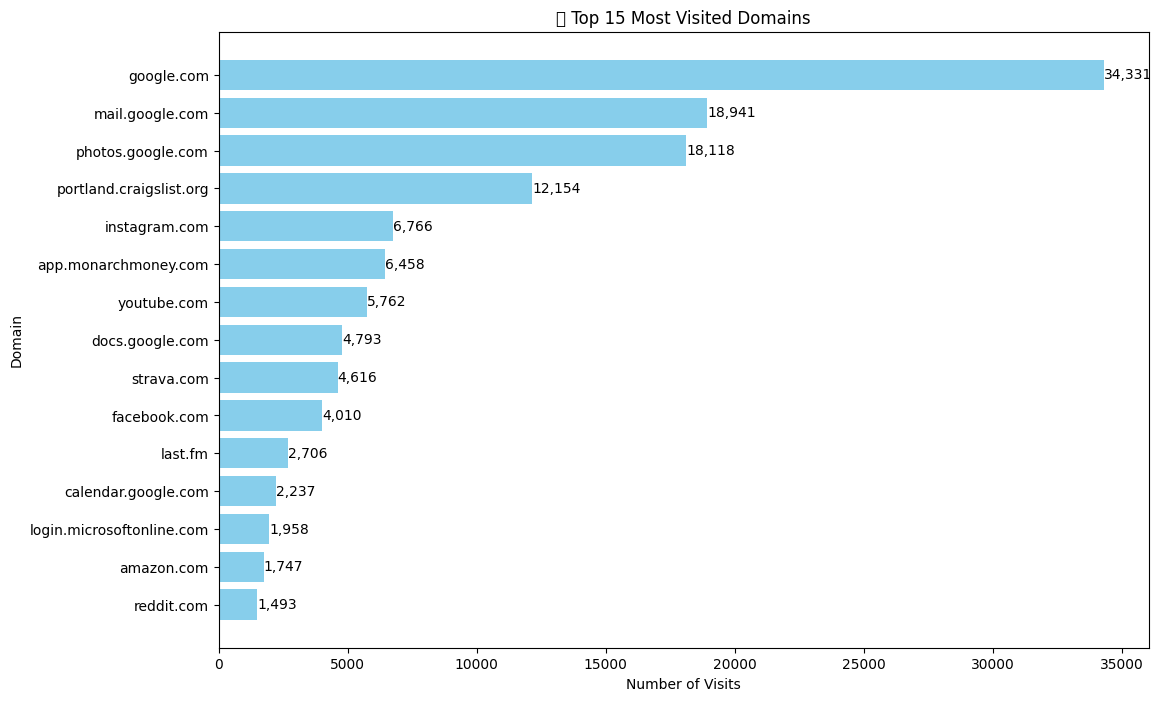

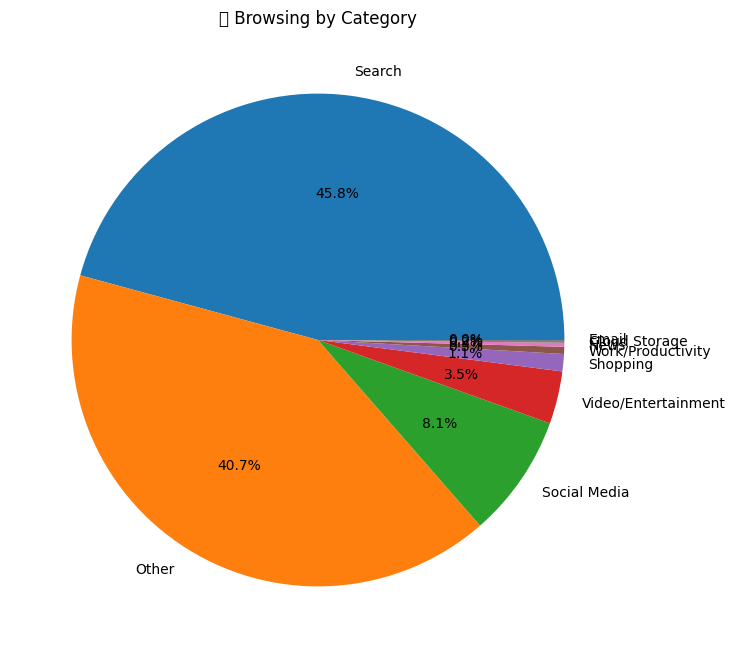

DateParseError: Unknown datetime string format, unable to parse: 2023-1655-09, at position 0

In [13]:
# Since seaborn is not installed, we'll just use matplotlib for visualizations
import matplotlib.pyplot as plt

plt.style.use('default')

# 1. Top Domains Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(
    range(len(top_domains_df.head(15))),
    top_domains_df.head(15)['Visits'],
    color='skyblue'
)
plt.title('🏆 Top 15 Most Visited Domains')
plt.xlabel('Number of Visits')
plt.ylabel('Domain')
plt.yticks(range(len(top_domains_df.head(15))), top_domains_df.head(15)['Domain'])
for i, v in enumerate(top_domains_df.head(15)['Visits']):
    plt.text(v, i, f'{v:,}', va='center')
plt.gca().invert_yaxis()
plt.show()

# 2. Domain Categories Pie Chart
plt.figure(figsize=(10, 8))
category_counts = df['category'].value_counts()
plt.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct='%1.1f%%'
)
plt.title('📂 Browsing by Category')
plt.show()

# 3. Visits Over Time (by month)
# Convert dates to datetime with a more recent base year to avoid overflow
monthly_visits = df.groupby('month').size().reset_index(name='visits')
monthly_visits['month'] = pd.to_datetime(monthly_visits['month'].astype(str).apply(lambda x: '2023-' + x))

plt.figure(figsize=(12, 6))
plt.plot(monthly_visits['month'], monthly_visits['visits'], marker='o')
plt.title('📅 Browsing Activity Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Additional visualizations
plt.figure(figsize=(12, 8))

# Top 15 domains horizontal bar chart
plt.subplot(2, 2, 1)
top_15_domains = domain_counts.head(15)
plt.barh(range(len(top_15_domains)), top_15_domains.values, color='skyblue')
plt.yticks(range(len(top_15_domains)), top_15_domains.index, fontsize=10)
plt.xlabel('Visit Count')
plt.title('Top 15 Domains by Visit Frequency')
plt.gca().invert_yaxis()

# Visit distribution histogram
plt.subplot(2, 2, 2)
visit_counts = domain_counts.values
plt.hist(visit_counts, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Visit Count per Domain')
plt.ylabel('Number of Domains')
plt.title('Distribution of Domain Visit Frequencies')
plt.yscale('log')

# Category breakdown
plt.subplot(2, 2, 3)
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Browsing Categories')

# Cumulative percentage
plt.subplot(2, 2, 4)
cumulative_pct = (domain_counts.cumsum() / total_visits * 100).head(50)
plt.plot(range(1, len(cumulative_pct) + 1), cumulative_pct, marker='o', markersize=4)
plt.xlabel('Top N Domains')
plt.ylabel('Cumulative Percentage of Visits')
plt.title('Cumulative Visit Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Visualization complete!")
print(f"🎯 The top {len(domain_counts[domain_counts >= 100])} domains (with 100+ visits) account for most of your browsing.")


## 💾 Export Results


In [14]:
# Export comprehensive results to CSV files
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# 1. Top domains summary
domain_summary = pd.DataFrame({
    'domain': domain_counts.index,
    'visits': domain_counts.values,
    'percentage': (domain_counts.values / total_visits * 100).round(3)
})
domain_summary['rank'] = range(1, len(domain_summary) + 1)
domain_summary = domain_summary[['rank', 'domain', 'visits', 'percentage']]

# 2. Full site summary  
site_summary = pd.DataFrame({
    'site': site_counts.index,
    'visits': site_counts.values,
    'percentage': (site_counts.values / total_visits * 100).round(3)
})
site_summary['rank'] = range(1, len(site_summary) + 1)
site_summary = site_summary[['rank', 'site', 'visits', 'percentage']]

# 3. Category summary
category_summary = pd.DataFrame({
    'category': category_counts.index,
    'visits': category_counts.values,
    'percentage': (category_counts.values / total_visits * 100).round(3)
})

# Save to CSV files
domain_file = f'chrome_domains_frequency_{timestamp}.csv'
site_file = f'chrome_sites_frequency_{timestamp}.csv' 
category_file = f'chrome_categories_frequency_{timestamp}.csv'

domain_summary.to_csv(domain_file, index=False)
site_summary.to_csv(site_file, index=False)
category_summary.to_csv(category_file, index=False)

print("💾 EXPORT COMPLETE!")
print("=" * 50)
print(f"📊 Domain frequency analysis: {domain_file}")
print(f"🔗 Site frequency analysis: {site_file}")  
print(f"📂 Category analysis: {category_file}")

# Summary statistics for final report
print(f"\n📈 FINAL SUMMARY:")
print(f"📊 Total visits analyzed: {total_visits:,}")
print(f"🌐 Unique domains: {len(domain_counts):,}")
print(f"🔗 Unique sites: {len(site_counts):,}")
print(f"📅 Date range: {df['date'].min()} to {df['date'].max()}")
print(f"📈 Average visits per day: {total_visits / ((df['date'].max() - df['date'].min()).days + 1):.0f}")
print(f"🏆 Most visited domain: {domain_counts.index[0]} ({domain_counts.iloc[0]:,} visits)")
print(f"🎯 Top 10 domains account for: {(domain_counts.head(10).sum() / total_visits * 100):.1f}% of visits")

# Show frequency distribution insights
single_visits = len(domain_counts[domain_counts == 1])
frequent_domains = len(domain_counts[domain_counts >= 10])
power_domains = len(domain_counts[domain_counts >= 100])

print(f"\n🔍 FREQUENCY INSIGHTS:")
print(f"🆕 Domains visited only once: {single_visits:,} ({single_visits/len(domain_counts)*100:.1f}%)")
print(f"🔄 Domains visited 10+ times: {frequent_domains:,}")
print(f"⭐ Domains visited 100+ times: {power_domains:,}")

print("\n✅ Site frequency analysis complete!")
print("📊 Check the exported CSV files for detailed frequency data.")


💾 EXPORT COMPLETE!
📊 Domain frequency analysis: chrome_domains_frequency_20250911_152231.csv
🔗 Site frequency analysis: chrome_sites_frequency_20250911_152231.csv
📂 Category analysis: chrome_categories_frequency_20250911_152231.csv

📈 FINAL SUMMARY:
📊 Total visits analyzed: 178,734
🌐 Unique domains: 4,345
🔗 Unique sites: 10,359
📅 Date range: 1655-09-12 to 1656-09-11
📈 Average visits per day: 488
🏆 Most visited domain: google.com (34,331 visits)
🎯 Top 10 domains account for: 64.9% of visits

🔍 FREQUENCY INSIGHTS:
🆕 Domains visited only once: 1,537 (35.4%)
🔄 Domains visited 10+ times: 816
⭐ Domains visited 100+ times: 98

✅ Site frequency analysis complete!
📊 Check the exported CSV files for detailed frequency data.
